In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import os
for dirname, _, filenames in os.walk('../data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/ozon_4_.ipynb
../data/sample_submit.csv
../data/smoto_submission_ensemble.csv
../data/smoto_submission_lightBGM.csv
../data/smoto_submission_Logistic.csv
../data/submission_ensemble.csv
../data/submission_lightBGM.csv
../data/submission_lightBGM2.csv
../data/submission_lightBGM2_2.csv
../data/submission_lightBGM3.csv
../data/submission_Logistic.csv
../data/submission_Logistic2.csv
../data/submission_Logistic3.csv
../data/sumoto_submission_Logistic2.csv
../data/sumoto_submission_Logistic3.csv
../data/sumoto_submission_Logistic3_2.csv
../data/sumoto_submission_Logistic3_3.csv
../data/sumoto_submission_Logistic4.csv
../data/sumoto_submission_Logistic4_2.csv
../data/test.tsv
../data/train.tsv
../data/.ipynb_checkpoints\ozon_4_-checkpoint.ipynb
../data/.ipynb_checkpoints\sample_submit-checkpoint.csv
../data/.ipynb_checkpoints\submission_ensemble-checkpoint.csv
../data/.ipynb_checkpoints\submission_lightBGM-checkpoint.csv
../data/.ipynb_checkpoints\submission_lightBGM3-checkpoint.csv

In [2]:
train_df = pd.read_table('../data/train.tsv', index_col='Date', parse_dates=True)
test_df = pd.read_table('../data/test.tsv', index_col='Date', parse_dates=True)
sample_sub = pd.read_csv('../data/sample_submit.csv')

# set type label
train_df['type'] = 'train'
test_df['type'] = 'test'

# all data
all_df = pd.concat([train_df, test_df], axis=0)

# OZONEが高い日の数
train_df[train_df["OZONE"]==1.0].sum


<bound method NDFrame._add_numeric_operations.<locals>.sum of               id  WSR0  WSR1  WSR2  WSR3  WSR4  WSR5  WSR6  WSR7  WSR8  ...  \
Date                                                                    ...   
1998-04-05    94   0.4   0.5   2.1   2.2   2.5   2.4   2.1   2.9   3.6  ...   
1998-04-11   100   0.0   0.6   0.4   0.3   0.1   0.3   0.2   1.4   2.6  ...   
1998-04-20   109   1.8   0.3   0.1   0.1   0.1   0.2   0.2   0.7   0.9  ...   
1998-04-23   112   0.5   0.1   0.1   0.1   0.1   0.2   0.3   0.8   1.2  ...   
1998-04-25   114   3.1   2.4   2.4   3.0   3.4   3.4   3.9   4.5   5.5  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
2001-05-23  1225   0.8   0.3   0.2   0.4   0.3   1.4   0.9   1.5   1.9  ...   
2001-06-15  1248   2.2   1.7   0.8   3.8   4.0   4.1   2.0   1.9   1.8  ...   
2001-06-16  1249   0.4   0.4   0.1   0.1   0.0   0.4   0.5   0.6   1.3  ...   
2001-06-18  1251   0.4   0.7   0.5   0.6   0.8   1.0   1.6   1.5   2.

## 学習する特徴量を作成
#### __欠損値処理__
→全部平均値で補完

#### __特徴量の削除/追加__
なんもしない

#### __データ変換__
→とりあえず全部標準化

In [3]:
import re
from imblearn.over_sampling import SMOTE

def eda(all_df):
    # データの追加,気温・風速の標準偏差
    #1時間ごとの気温・風速を取得
    T_data = all_df[['T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23']]
    WSR_data = all_df[['WSR0', 'WSR1', 'WSR2', 'WSR3', 'WSR4', 'WSR5', 'WSR6', 'WSR7', 'WSR8', 'WSR9', 'WSR10', 'WSR11', 'WSR12', 'WSR13', 'WSR14', 'WSR15', 'WSR16', 'WSR17', 'WSR18', 'WSR19', 'WSR20', 'WSR21', 'WSR22', 'WSR23']]
    # 行ごとの最高気温/風速を追加
    all_df['T_MAX'] = T_data.max(axis=1)
    all_df['WSR_MAX'] = WSR_data.std(axis=1)
    
    # ○○ヘクトパスカル面の風速を統一
    all_df['UV85'] = all_df['U85'] + all_df['V85']
    all_df['UV70'] = all_df['U70'] + all_df['V70']
    all_df['UV50'] = all_df['U50'] + all_df['V50']
    
    # 各ヘクトパスカル面の気温を足す
    # all_df['T_all'] = all_df['T85'] + all_df['T70'] + all_df['T50'] 
    

    # データの削除, T0~T23
    all_df = all_df.drop(columns=['T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23'])
    # データの削除, WSR0~WSR23
    all_df = all_df.drop(columns=['WSR0', 'WSR1', 'WSR2', 'WSR3', 'WSR4', 'WSR5', 'WSR6', 'WSR7', 'WSR8', 'WSR9', 'WSR10', 'WSR11', 'WSR12', 'WSR13', 'WSR14', 'WSR15', 'WSR16', 'WSR17', 'WSR18', 'WSR19', 'WSR20', 'WSR21', 'WSR22', 'WSR23'])
    
    # データの削除, SLP_
    all_df = all_df.drop(columns=['SLP_'])
    
    # ○○ヘクトパスカル面の風速の各方向を削除, U85,V85,U70,...
    all_df = all_df.drop(columns=['U85','V85','U70','V70','U50','V50'])
    
    # 各ヘクトパスカル面の気温を削除
    # all_df = all_df.drop(columns=['T85','T70','T50'])
    
    # 各ヘクトパスカル面の高度を削除(高度は海面気圧と気温から求まる)
    # all_df = all_df.drop(columns=['HT85','HT70','HT50'])
    
    # 海面気圧を削除？
    # all_df = all_df.drop(columns=['SLP'])
    
    return all_df


# 特徴量の削除/追加
all_df = eda(all_df)

# trainとtestに分けなおす
train_df = all_df[all_df['type'] == 'train']
test_df = all_df[all_df['type'] == 'test']
# train正解ラベル
y = train_df['OZONE']

# 学習に不要な特徴量を削除
train_df = train_df.drop(columns=['id', 'OZONE', 'type'])
test_df = test_df.drop(columns=['id', 'OZONE', 'type'])

# 欠損値を平均値で補完
train_df = train_df.fillna(train_df.mean())
test_df = test_df.fillna(test_df.mean())

print(f'train_df : \n{train_df}\n')
print(f'y : \n{y}\n')


# データ標準化(rightGBMのときはいらない)
scaler = StandardScaler()
train_df = pd.DataFrame(scaler.fit_transform(train_df), index = train_df.index, columns = train_df.columns)
test_df = pd.DataFrame(scaler.transform(test_df), index = test_df.index, columns = test_df.columns)

# 時系列(月)を特徴量に追加
train_df['month'] =  train_df.index.month
test_df['month'] =  test_df.index.month

# オーバーサンプリング
# SMOTEの初期化と適用
smote = SMOTE(random_state=42)
train_df, y = smote.fit_resample(train_df, y)

print(f'train_df : \n{train_df}\n')
print(f'y : \n{y}\n')

train_df : 
            WSR_PK  WSR_AV  T_PK  T_AV        T85      RH85         HT85  \
Date                                                                       
1998-01-01     5.5     3.1  19.1  12.5   6.700000  0.110000  1612.000000   
1998-01-02     5.5     3.4  22.4  17.8   9.000000  0.250000  1594.500000   
1998-01-03     5.6     3.5  22.2  18.7   9.000000  0.560000  1568.500000   
1998-01-04     4.7     3.2  19.6  18.7   9.900000  0.890000  1546.500000   
1998-01-05     3.7     2.3  26.0  21.1  13.539776  0.556758  1531.399585   
...            ...     ...   ...   ...        ...       ...          ...   
2001-06-29     3.3     1.7  30.6  25.7  17.400000  0.520000  1579.500000   
2001-06-30     3.3     2.0  31.7  26.9  16.000000  0.840000  1561.500000   
2001-07-01     4.1     2.0  27.9  24.8  16.500000  0.790000  1555.000000   
2001-07-02     3.1     1.4  30.8  24.8  17.100000  0.640000  1559.500000   
2001-07-03     2.6     1.4  30.9  26.2  16.800000  0.760000  1583.500000   


## 検証データ作成

In [4]:
from sklearn.model_selection import train_test_split
# 訓練データの一部を分割し検証データを作成
# 注意 :   
# shuffleをTrueにするとランダムに分割されます。
# この時、random_stateを定義していないとモデルの再現性が取れなくなるので、設定するよう心がけてください。
# test_size=0.2とすることで訓練データの２割を検証データにしている

X_train ,X_val ,y_train ,y_val = train_test_split(
    train_df, y, 
    test_size=0.3, shuffle=True,random_state=0
    )

## モデルの作成と評価
今回はロジェスティック回帰

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score,accuracy_score

# モデルを定義し学習
# model = LogisticRegression(max_iter=3000) 
model = LogisticRegression(max_iter=3000,class_weight='balanced') 
model.fit(X_train, y_train)
print(model.score(X_train, y_train))

# 訓練データに対しての予測を行い、正答率を算出
y_pred = model.predict(X_val)
print(balanced_accuracy_score(y_val, y_pred))

0.8182844243792325
0.7993727235936867


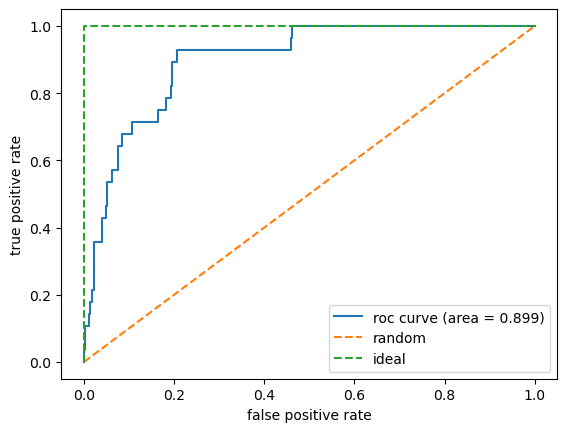

In [6]:
from sklearn.metrics import roc_curve, auc

y_score = model.predict_proba(X_val)[:, 1] # 検証データがクラス1に属する確率
fpr, tpr, thresholds = roc_curve(y_true=y_val, y_score=y_score)

plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], linestyle='--', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

In [7]:
# テストデータを予測
test_pred = model.predict(test_df)

# 行数で繰り返し予測値を代入
for index, row in sample_sub.iterrows():
    sample_sub.iloc[index,1] = np.where(test_pred[index]>=0.5, 1, 0)

# 結果を保存
# sample_sub.to_csv("../data/sumoto_submission_Logistic4.csv", index=False)
# sample_sub.to_csv("../data/sumoto_submission_Logistic4_2.csv", index=False)
# sample_sub.to_csv("../data/classweight_submission_Logistic4.csv", index=False)

In [8]:
test_pred.sum()

223.0